# 🚀 Multi-Currency Multi-Timeframe Deep Learning Training

## Системийн тодорхойлолт

Энэ notebook нь **3 өөр архитектураар** гурван модель сургана:

```
┌─────────────────────────────────────────────────┐
│  TRAINING DATA (ALL PAIRS COMBINED)             │
│  - EUR/USD, GBP/USD, USD/JPY                    │
│  - USD/CAD, USD/CHF, XAU/USD                    │
│  Total: Azure ML datasets                       │
└─────────────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────────────┐
│  3 PARALLEL MODELS WITH DIFFERENT ARCHITECTURES │
│                                                 │
│  ┌────────────────┬───────────────────────┐    │
│  │ 15-min Model   │ Transformer + LSTM    │    │
│  │ Expected: 88%  │ Focus: Quick scalping │    │
│  └────────────────┴───────────────────────┘    │
│                                                 │
│  ┌────────────────┬───────────────────────┐    │
│  │ 30-min Model   │ Bi-LSTM + Attention   │    │
│  │ Expected: 85%  │ Focus: Swing trades   │    │
│  └────────────────┴───────────────────────┘    │
│                                                 │
│  ┌────────────────┬───────────────────────┐    │
│  │ 60-min Model   │ CNN-LSTM Hybrid       │    │
│  │ Expected: 82%  │ Focus: Trend following│    │
│  └────────────────┴───────────────────────┘    │
└─────────────────────────────────────────────────┘
                    ↓
┌─────────────────────────────────────────────────┐
│  TEST ON ALL PAIRS                              │
│  - Overall accuracy per model                   │
│  - Per-pair performance breakdown               │
│  - Architecture comparison                       │
└─────────────────────────────────────────────────┘
```

## Зорилго

- 🎯 **15-минут (Transformer+LSTM):** 88%+ accuracy (scalping)
- 🎯 **30-минут (Bi-LSTM+Attention):** 85%+ accuracy (swing trading)
- 🎯 **60-минут (CNN-LSTM):** 82%+ accuracy (trend following)

## 📦 Import Libraries

In [9]:
# Install required packages with compatible versions
%pip install -q "numpy<2.0,>=1.23.5" "tensorflow>=2.15.0" seaborn scikit-learn joblib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import json

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"✅ Python version: {sys.version}")

✅ TensorFlow version: 2.20.0
✅ GPU available: []
✅ Python version: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


## ⚙️ Configuration

In [11]:
# Local directories for data, models and logs
TRAIN_DIR = Path('/home/azureuser/cloudfiles/code/data/train')
TEST_DIR = Path('/home/azureuser/cloudfiles/code/data/test')
MODELS_DIR = Path('/home/azureuser/cloudfiles/code/models')
LOGS_DIR = Path('/home/azureuser/cloudfiles/code/logs')

# Create directories
for timeframe in ['15min', '30min', '60min']:
    (MODELS_DIR / timeframe).mkdir(parents=True, exist_ok=True)
    (LOGS_DIR / timeframe / 'train').mkdir(parents=True, exist_ok=True)

# Currency pairs
CURRENCY_PAIRS = ['EUR_USD', 'GBP_USD', 'USD_JPY', 'USD_CAD', 'USD_CHF', 'XAU_USD']

# Training configuration - OPTIMIZED FOR 128GB RAM
CONFIG = {
    '15min': {
        'architecture': 'transformer_lstm',
        'resample_period': '15T',
        'sequence_length': 60,
        'prediction_steps': 1,
        'n_heads': 8,
        'ff_dim': 512,  # Increased from 256
        'lstm_units': [256, 128],  # Increased from [128, 64]
        'dropout': 0.3,
        'batch_size': 256,  # Increased from 64
        'epochs': 30,  # Increased from 20
        'learning_rate': 0.001,
        'description': 'Transformer + LSTM for quick scalping'
    },
    '30min': {
        'architecture': 'bilstm_attention',
        'resample_period': '30T',
        'sequence_length': 48,
        'prediction_steps': 1,
        'lstm_units': [256, 128],  # Increased from [128, 64]
        'attention_units': 256,  # Increased from 128
        'dropout': 0.3,
        'batch_size': 256,  # Increased from 64
        'epochs': 30,  # Increased from 20
        'learning_rate': 0.001,
        'description': 'Bi-LSTM + Attention for swing trades'
    },
    '60min': {
        'architecture': 'cnn_lstm',
        'resample_period': '60T',
        'sequence_length': 48,
        'prediction_steps': 1,
        'cnn_filters': [128, 256, 128],  # Increased from [64, 128, 64]
        'kernel_size': 3,
        'lstm_units': [256, 128],  # Increased from [128, 64]
        'dropout': 0.3,
        'batch_size': 256,  # Increased from 64
        'epochs': 30,  # Increased from 20
        'learning_rate': 0.001,
        'description': 'CNN-LSTM for trend following'
    }
}

print("✅ Configuration loaded - OPTIMIZED FOR 128GB RAM")
print(f"📂 Train directory: {TRAIN_DIR}")
print(f"📂 Test directory: {TEST_DIR}")
print(f"💾 Models directory: {MODELS_DIR}")
print(f"📊 Currency pairs: {', '.join(CURRENCY_PAIRS)}")
print("\n" + "="*80)
print("🏗️  ARCHITECTURE CONFIGURATION (ENHANCED)")
print("="*80)
for tf, cfg in CONFIG.items():
    print(f"\n{tf}:")
    print(f"  Architecture: {cfg['architecture']}")
    print(f"  Strategy: {cfg['description']}")
    print(f"  Batch size: {cfg['batch_size']} (4x увеличен)")
    print(f"  Epochs: {cfg['epochs']} (увеличен)")
    print(f"  Model size: Enhanced (larger units)")


✅ Configuration loaded - OPTIMIZED FOR 128GB RAM
📂 Train directory: /home/azureuser/cloudfiles/code/data/train
📂 Test directory: /home/azureuser/cloudfiles/code/data/test
💾 Models directory: /home/azureuser/cloudfiles/code/models
📊 Currency pairs: EUR_USD, GBP_USD, USD_JPY, USD_CAD, USD_CHF, XAU_USD

🏗️  ARCHITECTURE CONFIGURATION (ENHANCED)

15min:
  Architecture: transformer_lstm
  Strategy: Transformer + LSTM for quick scalping
  Batch size: 256 (4x увеличен)
  Epochs: 30 (увеличен)
  Model size: Enhanced (larger units)

30min:
  Architecture: bilstm_attention
  Strategy: Bi-LSTM + Attention for swing trades
  Batch size: 256 (4x увеличен)
  Epochs: 30 (увеличен)
  Model size: Enhanced (larger units)

60min:
  Architecture: cnn_lstm
  Strategy: CNN-LSTM for trend following
  Batch size: 256 (4x увеличен)
  Epochs: 30 (увеличен)
  Model size: Enhanced (larger units)


## 📥 Load Data from Azure ML

In [12]:
# Load data from local files
def load_local_data(data_dir, data_type='train'):
    """
    Load data from local directory and automatically detect currency pair from filename
    """
    print(f"\n{'='*80}")
    print(f"📂 LOADING {data_type.upper()} DATA FROM LOCAL FILES")
    print(f"{'='*80}\n")
    
    data_path = Path(data_dir)
    
    if not data_path.exists():
        print(f"❌ Directory not found: {data_path}")
        return None, None
    
    # Find all CSV and Parquet files
    csv_files = list(data_path.glob('**/*.csv'))
    parquet_files = list(data_path.glob('**/*.parquet'))
    
    all_files = csv_files + parquet_files
    
    if not all_files:
        print(f"❌ No CSV or Parquet files found in: {data_path}")
        return None, None
    
    print(f"Found {len(csv_files)} CSV files and {len(parquet_files)} Parquet files")
    
    # Load all files
    dfs = []
    for file in all_files:
        print(f"  Loading: {file.name}")
        try:
            if file.suffix == '.csv':
                df = pd.read_csv(file)
            else:
                df = pd.read_parquet(file)
            
            # Auto-detect pair from filename if not present
            if 'pair' not in df.columns:
                filename = file.stem
                if '_' in filename:
                    parts = filename.split('_')
                    # Find currency pair pattern
                    for i in range(len(parts)-1):
                        if len(parts[i]) == 3 and len(parts[i+1]) == 3:
                            pair = f"{parts[i]}/{parts[i+1]}"
                            df['pair'] = pair
                            print(f"    → Detected pair: {pair}")
                            break
                    
                    if 'pair' not in df.columns:
                        if len(parts) >= 2 and len(parts[0]) in [3, 4]:
                            pair = f"{parts[0]}/{parts[1]}"
                            df['pair'] = pair
                            print(f"    → Detected pair: {pair}")
                    
                    if 'pair' not in df.columns:
                        print(f"    ⚠️  Could not detect pair, skipping file")
                        continue
            
            dfs.append(df)
        except Exception as e:
            print(f"    ⚠️  Failed to load {file.name}: {e}")
    
    if not dfs:
        print("❌ Failed to load any files")
        return None, None
    
    # Combine all dataframes
    df_all = pd.concat(dfs, ignore_index=True)
    
    # Filter out invalid pairs
    if 'pair' in df_all.columns:
        valid_pairs = ['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CAD', 'USD/CHF', 'XAU/USD']
        invalid_pairs = [p for p in df_all['pair'].unique() if p not in valid_pairs]
        if invalid_pairs:
            print(f"  ⚠️  Filtering out invalid pairs: {invalid_pairs}")
            df_all = df_all[df_all['pair'].isin(valid_pairs)]
    
    print(f"\n✅ Successfully loaded data")
    print(f"Total rows: {len(df_all):,}")
    print(f"Columns: {df_all.columns.tolist()}")
    print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Set datetime index
    time_cols = [col for col in df_all.columns if 'time' in col.lower() or 'date' in col.lower()]
    if time_cols:
        print(f"Setting '{time_cols[0]}' as datetime index")
        df_all[time_cols[0]] = pd.to_datetime(df_all[time_cols[0]])
        df_all = df_all.set_index(time_cols[0])
        df_all = df_all.sort_index()
    
    # Generate pair statistics
    pair_stats = []
    if 'pair' in df_all.columns:
        print(f"\n📊 Currency pairs found:")
        for pair in df_all['pair'].unique():
            df_pair = df_all[df_all['pair'] == pair]
            pair_stats.append({
                'pair': pair,
                'rows': len(df_pair),
                'start': df_pair.index.min() if isinstance(df_pair.index, pd.DatetimeIndex) else 'N/A',
                'end': df_pair.index.max() if isinstance(df_pair.index, pd.DatetimeIndex) else 'N/A'
            })
            print(f"  {pair}: {len(df_pair):,} rows")
    
    stats_df = pd.DataFrame(pair_stats) if pair_stats else None
    return df_all, stats_df

# Load training and test data
print("="*80)
print("📥 LOADING ALL DATA")
print("="*80)

df_train_all, train_stats = load_local_data(TRAIN_DIR, 'train')
df_test_all, test_stats = load_local_data(TEST_DIR, 'test')

# Summary
print("\n" + "="*80)
print("DATA LOADING SUMMARY")
print("="*80)
if df_train_all is not None and df_test_all is not None:
    print("✅ Both train and test datasets loaded successfully!")
    print(f"   Train: {len(df_train_all):,} rows")
    print(f"   Test:  {len(df_test_all):,} rows")
    print("\n🎉 Ready to proceed with feature engineering and training!")
else:
    print("❌ Data loading failed. Please check the error messages above.")

📥 LOADING ALL DATA

📂 LOADING TRAIN DATA FROM LOCAL FILES

Found 6 CSV files and 0 Parquet files
  Loading: EUR_USD_1min.csv
    → Detected pair: EUR/USD
  Loading: GBP_USD_1min.csv
    → Detected pair: EUR/USD
  Loading: GBP_USD_1min.csv
    → Detected pair: GBP/USD
  Loading: USD_CAD_1min.csv
    → Detected pair: GBP/USD
  Loading: USD_CAD_1min.csv
    → Detected pair: USD/CAD
  Loading: USD_CHF_1min.csv
    → Detected pair: USD/CAD
  Loading: USD_CHF_1min.csv
    → Detected pair: USD/CHF
  Loading: USD_JPY_1min.csv
    → Detected pair: USD/CHF
  Loading: USD_JPY_1min.csv
    → Detected pair: USD/JPY
  Loading: XAU_USD_1min.csv
    → Detected pair: USD/JPY
  Loading: XAU_USD_1min.csv
    → Detected pair: XAU/USD
    → Detected pair: XAU/USD

✅ Successfully loaded data
Total rows: 11,055,816
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'pair']

✅ Successfully loaded data
Total rows: 11,055,816
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'pair']

## 🔧 Technical Indicators & Feature Engineering

In [13]:
def calculate_all_features(df):
    """Calculate comprehensive technical indicators"""
    df = df.copy()
    
    # Price-based features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['hl_ratio'] = (df['high'] - df['low']) / df['close']
    df['co_ratio'] = (df['close'] - df['open']) / df['open']
    
    # Moving Averages
    for period in [5, 10, 20, 50]:
        df[f'sma_{period}'] = df['close'].rolling(window=period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    
    # ATR
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['atr'] = true_range.rolling(14).mean()
    
    # Stochastic Oscillator
    low_14 = df['low'].rolling(window=14).min()
    high_14 = df['high'].rolling(window=14).max()
    df['stoch_k'] = 100 * ((df['close'] - low_14) / (high_14 - low_14))
    df['stoch_d'] = df['stoch_k'].rolling(window=3).mean()
    
    # Volume features
    df['volume_sma'] = df['tick_volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['tick_volume'] / df['volume_sma']
    
    # Momentum
    df['momentum'] = df['close'] - df['close'].shift(10)
    df['roc'] = ((df['close'] - df['close'].shift(10)) / df['close'].shift(10)) * 100
    
    return df

def create_sequences(X, y, sequence_length):
    """Create sequences for LSTM/Transformer models"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    
    return np.array(X_seq), np.array(y_seq)

print("✅ Feature engineering functions defined")

✅ Feature engineering functions defined


## 🏗️ Model Architectures

In [20]:
def build_transformer_lstm_model(sequence_length, n_features, n_heads=8, ff_dim=256, 
                                  lstm_units=[128, 64], dropout_rate=0.3, n_classes=3):
    """Transformer + LSTM architecture for 15-min scalping"""
    
    inputs = layers.Input(shape=(sequence_length, n_features))
    
    # Multi-Head Attention
    attention_output = layers.MultiHeadAttention(
        num_heads=n_heads, 
        key_dim=n_features // n_heads
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    
    # Feed Forward Network
    ff_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    ff_output = layers.Dense(n_features)(ff_output)
    ff_output = layers.LayerNormalization(epsilon=1e-6)(ff_output + attention_output)
    
    # LSTM layers
    x = layers.LSTM(lstm_units[0], return_sequences=True)(ff_output)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.LSTM(lstm_units[1])(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Multi-task output
    direction_output = layers.Dense(n_classes, activation='softmax', name='direction')(x)
    confidence_output = layers.Dense(1, activation='sigmoid', name='confidence')(x)
    
    model = keras.Model(inputs=inputs, outputs=[direction_output, confidence_output])
    return model


def build_bilstm_attention_model(sequence_length, n_features, lstm_units=[128, 64],
                                   attention_units=128, dropout_rate=0.3, n_classes=3):
    """Bi-LSTM + Attention architecture for 30-min swing trading"""
    
    import tensorflow as tf_internal
    
    inputs = layers.Input(shape=(sequence_length, n_features))
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(lstm_units[0], return_sequences=True))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units[1], return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Custom Attention Mechanism
    attention = layers.Dense(attention_units, activation='tanh')(x)
    attention = layers.Dense(1, activation='softmax')(attention)
    attention = layers.Flatten()(attention)
    attention = layers.RepeatVector(lstm_units[1] * 2)(attention)
    attention = layers.Permute([2, 1])(attention)
    
    # Apply attention
    x = layers.Multiply()([x, attention])
    x = layers.Lambda(lambda xin: tf_internal.reduce_sum(xin, axis=1), 
                      output_shape=(lstm_units[1] * 2,))(x)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Multi-task output
    direction_output = layers.Dense(n_classes, activation='softmax', name='direction')(x)
    confidence_output = layers.Dense(1, activation='sigmoid', name='confidence')(x)
    
    model = keras.Model(inputs=inputs, outputs=[direction_output, confidence_output])
    return model


def build_cnn_lstm_model(sequence_length, n_features, cnn_filters=[64, 128, 64],
                          kernel_size=3, lstm_units=[128, 64], dropout_rate=0.3, n_classes=3):
    """CNN-LSTM hybrid architecture for 60-min trend following"""
    
    inputs = layers.Input(shape=(sequence_length, n_features))
    
    # CNN layers for feature extraction
    x = inputs
    for filters in cnn_filters:
        x = layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
        x = layers.Dropout(dropout_rate)(x)
    
    # LSTM layers for temporal modeling
    x = layers.LSTM(lstm_units[0], return_sequences=True)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.LSTM(lstm_units[1])(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Dense layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Multi-task output
    direction_output = layers.Dense(n_classes, activation='softmax', name='direction')(x)
    confidence_output = layers.Dense(1, activation='sigmoid', name='confidence')(x)
    
    model = keras.Model(inputs=inputs, outputs=[direction_output, confidence_output])
    return model


print("✅ Model architectures defined:")
print("   - Transformer + LSTM (15-min)")
print("   - Bi-LSTM + Attention (30-min)")
print("   - CNN-LSTM Hybrid (60-min)")

✅ Model architectures defined:
   - Transformer + LSTM (15-min)
   - Bi-LSTM + Attention (30-min)
   - CNN-LSTM Hybrid (60-min)


## 🔧 Data Preparation for Multi-Currency

In [15]:
def prepare_multi_currency_data(df, timeframe_config, fit_scaler=None, fit_encoder=None):
    """
    Prepare data for specific timeframe with multi-currency support
    """
    print(f"\n🔄 Processing multi-currency data for {timeframe_config['resample_period']}...")
    
    all_pairs_data = []
    
    # Detect currency pairs
    if 'pair' in df.columns:
        pairs_in_data = df['pair'].unique()
    else:
        pairs_in_data = ['UNKNOWN']
        df['pair'] = 'UNKNOWN'
    
    print(f"Found pairs: {pairs_in_data}")
    
    # Process each pair separately then combine
    for pair in pairs_in_data:
        print(f"  Processing {pair}...")
        
        # Filter data for this pair
        df_pair = df[df['pair'] == pair].copy()
        df_pair = df_pair.drop('pair', axis=1)
        
        if len(df_pair) == 0:
            continue
        
        # Ensure datetime index
        if not isinstance(df_pair.index, pd.DatetimeIndex):
            if 'time' in df_pair.columns:
                df_pair['time'] = pd.to_datetime(df_pair['time'])
                df_pair = df_pair.set_index('time')
            elif 'timestamp' in df_pair.columns:
                df_pair['timestamp'] = pd.to_datetime(df_pair['timestamp'])
                df_pair = df_pair.set_index('timestamp')
        
        # Resample (use 'volume' column if 'tick_volume' doesn't exist)
        volume_col = 'tick_volume' if 'tick_volume' in df_pair.columns else 'volume'
        df_resampled = df_pair.resample(timeframe_config['resample_period']).agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            volume_col: 'sum'
        }).dropna()
        
        # Rename volume column to tick_volume for consistency
        if volume_col == 'volume':
            df_resampled = df_resampled.rename(columns={'volume': 'tick_volume'})
        
        if len(df_resampled) == 0:
            continue
        
        # Calculate features
        df_features = calculate_all_features(df_resampled)
        
        # Create labels
        prediction_steps = timeframe_config['prediction_steps']
        df_features['future_return'] = df_features['close'].shift(-prediction_steps) / df_features['close'] - 1
        
        threshold = 0.0005
        conditions = [
            df_features['future_return'] < -threshold,
            (df_features['future_return'] >= -threshold) & (df_features['future_return'] <= threshold),
            df_features['future_return'] > threshold
        ]
        df_features['label'] = np.select(conditions, [0, 1, 2], default=1)
        
        # Add pair identifier back
        df_features['pair'] = pair
        
        df_features = df_features.dropna()
        all_pairs_data.append(df_features)
        print(f"    ✅ {len(df_features):,} rows")
    
    # Combine all pairs
    df_combined = pd.concat(all_pairs_data, axis=0)
    df_combined = df_combined.sort_index()
    
    print(f"\n✅ Combined: {len(df_combined):,} rows")
    print(f"\n📊 Label distribution:")
    print(df_combined['label'].value_counts())
    print(f"\nClass percentages:")
    print(df_combined['label'].value_counts(normalize=True) * 100)
    
    # Encode pair as one-hot
    if fit_encoder is None:
        pair_encoder = LabelEncoder()
        pair_encoded = pair_encoder.fit_transform(df_combined['pair'])
    else:
        pair_encoder = fit_encoder
        pair_encoded = pair_encoder.transform(df_combined['pair'])
    
    # One-hot encode pair
    pair_onehot = pd.get_dummies(pair_encoded, prefix='pair')
    
    # Separate features and labels
    feature_cols = [col for col in df_combined.columns 
                   if col not in ['label', 'future_return', 'open', 'high', 'low', 'close', 'pair', 'tick_volume']]
    
    X = df_combined[feature_cols].values
    y = df_combined['label'].values
    
    # Add pair encoding to features
    X = np.concatenate([X, pair_onehot.values], axis=1)
    feature_cols_with_pair = feature_cols + [f'pair_{i}' for i in range(len(pair_onehot.columns))]
    
    # Normalize
    print("\n🔄 Normalizing features...")
    if fit_scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        scaler = fit_scaler
        X_scaled = scaler.transform(X)
    
    print(f"✅ Final shape: X={X_scaled.shape}, y={y.shape}")
    print(f"✅ Total features: {len(feature_cols_with_pair)}")
    
    return X_scaled, y, scaler, pair_encoder, feature_cols_with_pair, df_combined['pair'].values


print("✅ Multi-currency data preparation function defined")

✅ Multi-currency data preparation function defined


## 🏋️ Training Function

In [16]:
def calculate_weighted_accuracy(y_true, y_pred):
    """
    Calculate weighted accuracy for trading predictions
    
    Scoring rules:
    - Correct prediction (BUY->BUY, SELL->SELL, NEUTRAL->NEUTRAL): 1.0
    - Opposite direction (BUY->SELL or SELL->BUY): 0.0 (major error!)
    - Missed move (BUY/SELL->NEUTRAL or NEUTRAL->BUY/SELL): 0.5 (minor error)
    
    Args:
        y_true: True labels (0=SELL, 1=NEUTRAL, 2=BUY)
        y_pred: Predicted labels (0=SELL, 1=NEUTRAL, 2=BUY)
    
    Returns:
        weighted_accuracy: Score between 0 and 1
        breakdown: Dict with detailed breakdown
    """
    scores = []
    
    # Count different error types
    correct = 0
    opposite = 0  # BUY->SELL or SELL->BUY
    neutral_miss = 0  # Predicted NEUTRAL when should move
    false_signal = 0  # Predicted move when should be NEUTRAL
    
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label == pred_label:
            # Exact match
            scores.append(1.0)
            correct += 1
        elif (true_label == 0 and pred_label == 2) or (true_label == 2 and pred_label == 0):
            # Opposite direction - WORST error
            scores.append(0.0)
            opposite += 1
        elif true_label == 1 and pred_label != 1:
            # False signal (predicted move on neutral)
            scores.append(0.5)
            false_signal += 1
        elif true_label != 1 and pred_label == 1:
            # Missed move (predicted neutral on actual move)
            scores.append(0.5)
            neutral_miss += 1
        else:
            # Shouldn't happen, but handle it
            scores.append(0.3)
    
    weighted_acc = np.mean(scores)
    
    breakdown = {
        'weighted_accuracy': weighted_acc,
        'simple_accuracy': accuracy_score(y_true, y_pred),
        'total_samples': len(y_true),
        'correct': correct,
        'opposite_errors': opposite,
        'neutral_misses': neutral_miss,
        'false_signals': false_signal,
        'correct_pct': correct / len(y_true) * 100,
        'opposite_pct': opposite / len(y_true) * 100,
        'neutral_miss_pct': neutral_miss / len(y_true) * 100,
        'false_signal_pct': false_signal / len(y_true) * 100
    }
    
    return weighted_acc, breakdown


def print_accuracy_breakdown(breakdown, model_name="Model"):
    """Pretty print accuracy breakdown"""
    print(f"\n{'='*80}")
    print(f"📊 {model_name} - DETAILED ACCURACY BREAKDOWN")
    print(f"{'='*80}")
    
    print(f"\n🎯 Weighted Accuracy: {breakdown['weighted_accuracy']*100:.2f}%")
    print(f"📈 Simple Accuracy:   {breakdown['simple_accuracy']*100:.2f}%")
    print(f"📊 Total Samples:     {breakdown['total_samples']:,}")
    
    print(f"\n✅ Correct Predictions:        {breakdown['correct']:>7,} ({breakdown['correct_pct']:.2f}%)")
    print(f"❌ Opposite Direction Errors: {breakdown['opposite_errors']:>7,} ({breakdown['opposite_pct']:.2f}%) ← CRITICAL!")
    print(f"⚠️  Neutral Misses:            {breakdown['neutral_misses']:>7,} ({breakdown['neutral_miss_pct']:.2f}%)")
    print(f"⚠️  False Signals:             {breakdown['false_signals']:>7,} ({breakdown['false_signal_pct']:.2f}%)")
    
    # Score impact
    print(f"\n💡 Score Impact:")
    print(f"   Correct:          {breakdown['correct']:>7,} × 1.0 = {breakdown['correct']:.0f}")
    print(f"   Opposite errors:  {breakdown['opposite_errors']:>7,} × 0.0 = 0")
    print(f"   Neutral/False:    {breakdown['neutral_misses'] + breakdown['false_signals']:>7,} × 0.5 = {(breakdown['neutral_misses'] + breakdown['false_signals']) * 0.5:.0f}")
    print(f"   " + "─"*50)
    print(f"   Total score:      {breakdown['weighted_accuracy'] * breakdown['total_samples']:.0f} / {breakdown['total_samples']:,}")
    
    print(f"\n{'='*80}")


print("✅ Weighted accuracy functions defined")

✅ Weighted accuracy functions defined


In [17]:
def train_multi_currency_model(timeframe, df_train, df_test):
    """Train model on ALL currency pairs combined"""
    
    print("\n" + "="*80)
    print(f"🚀 TRAINING {timeframe.upper()} MODEL ON ALL PAIRS")
    print("="*80 + "\n")
    
    config = CONFIG[timeframe]
    
    # Prepare training data
    print(f"🔧 Preparing training data (all pairs)...")
    X_train, y_train, scaler, pair_encoder, feature_cols, train_pairs = prepare_multi_currency_data(
        df_train, config
    )
    
    # Prepare test data
    print(f"\n🔧 Preparing test data (all pairs)...")
    X_test, y_test, _, _, _, test_pairs = prepare_multi_currency_data(
        df_test, config, fit_scaler=scaler, fit_encoder=pair_encoder
    )
    
    # Create sequences
    print(f"\n🔄 Creating sequences (length={config['sequence_length']})...")
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, config['sequence_length'])
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, config['sequence_length'])
    
    # Keep track of pairs for test sequences
    test_pairs_seq = test_pairs[config['sequence_length']:]
    
    print(f"✅ Training sequences: {X_train_seq.shape}")
    print(f"✅ Test sequences: {X_test_seq.shape}")
    
    # Convert to float32 to save memory
    X_train_seq = X_train_seq.astype(np.float32)
    X_test_seq = X_test_seq.astype(np.float32)
    y_train_seq = y_train_seq.astype(np.int32)
    y_test_seq = y_test_seq.astype(np.int32)
    print(f"✅ Converted to float32/int32 for memory efficiency")
    
    # Split validation
    X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
        X_train_seq, y_train_seq, test_size=0.2, random_state=42, stratify=y_train_seq
    )
    
    print(f"\n📊 Final splits:")
    print(f"   Train: {X_train_seq.shape}")
    print(f"   Val:   {X_val_seq.shape}")
    print(f"   Test:  {X_test_seq.shape}")
    
    # Build model
    print(f"\n🏗️  Building {config['architecture']} model...")
    print(f"📝 Strategy: {config['description']}")
    n_features = X_train_seq.shape[2]
    
    if timeframe == '15min':
        model = build_transformer_lstm_model(
            sequence_length=config['sequence_length'],
            n_features=n_features,
            n_heads=config['n_heads'],
            ff_dim=config['ff_dim'],
            lstm_units=config['lstm_units'],
            dropout_rate=config['dropout'],
            n_classes=3
        )
    elif timeframe == '30min':
        model = build_bilstm_attention_model(
            sequence_length=config['sequence_length'],
            n_features=n_features,
            lstm_units=config['lstm_units'],
            attention_units=config['attention_units'],
            dropout_rate=config['dropout'],
            n_classes=3
        )
    else:  # 60min
        model = build_cnn_lstm_model(
            sequence_length=config['sequence_length'],
            n_features=n_features,
            cnn_filters=config['cnn_filters'],
            kernel_size=config['kernel_size'],
            lstm_units=config['lstm_units'],
            dropout_rate=config['dropout'],
            n_classes=3
        )
    
    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=config['learning_rate']),
        loss={
            'direction': 'sparse_categorical_crossentropy',
            'confidence': 'mse'
        },
        loss_weights={'direction': 1.0, 'confidence': 0.5},
        metrics={
            'direction': ['accuracy'],
            'confidence': ['mae']
        }
    )
    
    print(model.summary())
    
    # Callbacks
    model_path = MODELS_DIR / timeframe / f"multi_currency_{timeframe}_best.keras"
    log_dir = LOGS_DIR / timeframe / 'train' / datetime.now().strftime("%Y%m%d-%H%M%S")
    
    callbacks_list = [
        callbacks.ModelCheckpoint(
            filepath=str(model_path),
            monitor='val_direction_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        callbacks.EarlyStopping(
            monitor='val_direction_accuracy',
            patience=5,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.TensorBoard(
            log_dir=str(log_dir),
            histogram_freq=0
        )
    ]
    
    # Train
    print(f"\n🏋️  Training model on ALL currency pairs...")
    print(f"📊 Batch size: {config['batch_size']}")
    print(f"📊 Epochs: {config['epochs']}")
    
    history = model.fit(
        X_train_seq,
        {
            'direction': y_train_seq,
            'confidence': np.ones_like(y_train_seq, dtype=np.float32)
        },
        validation_data=(
            X_val_seq,
            {
                'direction': y_val_seq,
                'confidence': np.ones_like(y_val_seq, dtype=np.float32)
            }
        ),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Test
    print(f"\n📊 Testing on all pairs...")
    predictions = model.predict(X_test_seq, batch_size=config['batch_size'])
    y_pred = np.argmax(predictions[0], axis=1)
    y_confidence = predictions[1].flatten()
    
    # Calculate both simple and weighted accuracy
    simple_accuracy = accuracy_score(y_test_seq, y_pred)
    weighted_accuracy, accuracy_breakdown = calculate_weighted_accuracy(y_test_seq, y_pred)
    
    print("\n" + "="*80)
    print(f"📈 OVERALL TEST RESULTS FOR {timeframe.upper()}")
    print("="*80)
    print(f"\n🎯 Simple Accuracy:   {simple_accuracy*100:.2f}%")
    print(f"⭐ Weighted Accuracy: {weighted_accuracy*100:.2f}% (penalizes opposite direction errors)")
    
    # Print detailed breakdown
    print_accuracy_breakdown(accuracy_breakdown, f"{timeframe.upper()} Model")
    
    print("\n📊 Classification Report:")
    print(classification_report(y_test_seq, y_pred, target_names=['SELL', 'NEUTRAL', 'BUY']))
    
    # Per-pair accuracy
    print("\n" + "="*80)
    print("📊 PER-PAIR ACCURACY BREAKDOWN")
    print("="*80 + "\n")
    
    pair_results = []
    for pair in np.unique(test_pairs_seq):
        mask = test_pairs_seq == pair
        if mask.sum() > 0:
            pair_simple_acc = accuracy_score(y_test_seq[mask], y_pred[mask])
            pair_weighted_acc, _ = calculate_weighted_accuracy(y_test_seq[mask], y_pred[mask])
            pair_results.append({
                'Pair': pair,
                'Samples': mask.sum(),
                'Simple_Accuracy': f"{pair_simple_acc*100:.2f}%",
                'Weighted_Accuracy': f"{pair_weighted_acc*100:.2f}%"
            })
            print(f"{pair:15s}: Simple={pair_simple_acc*100:>5.2f}% | Weighted={pair_weighted_acc*100:>5.2f}% ({mask.sum():,} samples)")
    
    # Save artifacts
    scaler_path = MODELS_DIR / timeframe / f"multi_currency_{timeframe}_scaler.pkl"
    encoder_path = MODELS_DIR / timeframe / f"multi_currency_{timeframe}_encoder.pkl"
    
    joblib.dump(scaler, scaler_path)
    joblib.dump(pair_encoder, encoder_path)
    
    metadata = {
        'timeframe': timeframe,
        'architecture': config['architecture'],
        'strategy': config['description'],
        'training_mode': 'multi_currency',
        'pairs': [str(p) for p in np.unique(test_pairs_seq)],
        'n_features': int(n_features),
        'sequence_length': int(config['sequence_length']),
        'feature_columns': feature_cols,
        'train_samples': int(len(X_train_seq)),
        'test_samples': int(len(X_test_seq)),
        'simple_accuracy': float(simple_accuracy),
        'weighted_accuracy': float(weighted_accuracy),
        'accuracy_breakdown': {
            'correct': int(accuracy_breakdown['correct']),
            'opposite_errors': int(accuracy_breakdown['opposite_errors']),
            'neutral_misses': int(accuracy_breakdown['neutral_misses']),
            'false_signals': int(accuracy_breakdown['false_signals'])
        },
        'per_pair_results': [{k: (int(v) if isinstance(v, (np.integer, np.int64)) else v) 
                              for k, v in pr.items()} for pr in pair_results],
        'training_date': datetime.now().isoformat()
    }
    
    metadata_path = MODELS_DIR / timeframe / f"multi_currency_{timeframe}_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\n💾 Model saved: {model_path}")
    print(f"💾 Scaler saved: {scaler_path}")
    print(f"💾 Encoder saved: {encoder_path}")
    print(f"💾 Metadata saved: {metadata_path}")
    
    return {
        'model': model,
        'history': history,
        'simple_accuracy': simple_accuracy,
        'weighted_accuracy': weighted_accuracy,
        'accuracy_breakdown': accuracy_breakdown,
        'predictions': y_pred,
        'confidence': y_confidence,
        'true_labels': y_test_seq,
        'test_pairs': test_pairs_seq,
        'pair_results': pair_results
    }


print("✅ Training function defined")

✅ Training function defined


## 🚀 Train All Models

Эхлээд датасэтүүд зөв уншигдсан эсэхийг шалгаад, дараа нь гурван моделийг дараалан сургана.

In [ ]:
# Check if data is loaded
if df_train_all is None or df_test_all is None:
    print("❌ Data not loaded properly. Please check Azure ML dataset loading.")
    print("You may need to:")
    print("  1. Install mltable: pip install mltable")
    print("  2. Or manually download data from Azure ML")
else:
    print("✅ Data is ready for training")
    print(f"Train: {len(df_train_all):,} rows")
    print(f"Test: {len(df_test_all):,} rows")

### 🎯 Model 1: 15-Minute (Transformer + LSTM)

In [18]:
# Train 15-minute model
if df_train_all is not None and df_test_all is not None:
    try:
        print("="*80)
        print("🎯 TRAINING 15-MINUTE MODEL (TRANSFORMER + LSTM)")
        print("="*80)
        
        result_15min = train_multi_currency_model('15min', df_train_all, df_test_all)
        
        print(f"\n✅ 15-minute model training completed!")
        print(f"🎯 Simple Accuracy:   {result_15min['simple_accuracy']*100:.2f}%")
        print(f"⭐ Weighted Accuracy: {result_15min['weighted_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"\n❌ Error training 15-minute model: {str(e)}")
        import traceback
        traceback.print_exc()
        result_15min = None
else:
    print("⚠️  Skipping 15-minute model - data not available")
    result_15min = None

🎯 TRAINING 15-MINUTE MODEL (TRANSFORMER + LSTM)

🚀 TRAINING 15MIN MODEL ON ALL PAIRS

🔧 Preparing training data (all pairs)...

🔄 Processing multi-currency data for 15T...
Found pairs: ['EUR/USD' 'USD/JPY' 'USD/CHF' 'USD/CAD' 'GBP/USD' 'XAU/USD']
  Processing EUR/USD...
    ✅ 124,670 rows
  Processing USD/JPY...
    ✅ 124,670 rows
  Processing USD/JPY...
    ✅ 124,664 rows
  Processing USD/CHF...
    ✅ 124,664 rows
  Processing USD/CHF...
    ✅ 124,589 rows
  Processing USD/CAD...
    ✅ 124,589 rows
  Processing USD/CAD...
    ✅ 124,640 rows
  Processing GBP/USD...
    ✅ 124,640 rows
  Processing GBP/USD...
    ✅ 124,650 rows
  Processing XAU/USD...
    ✅ 124,650 rows
  Processing XAU/USD...
    ✅ 118,112 rows

✅ Combined: 741,325 rows

📊 Label distribution:
1    559929
2     91125
0     90271
Name: label, dtype: int64

Class percentages:
1    75.53084
2    12.29218
0    12.17698
Name: label, dtype: float64
    ✅ 118,112 rows

✅ Combined: 741,325 rows

📊 Label distribution:
1    559929

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 33)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 33)    │      4,353 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 60, 33)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 33)    │          0 │ dropout_7[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 33)    │         66 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 60, 512)   │     17,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 60, 512)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 60, 33)    │     16,929 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 33)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 33)    │         66 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 60, 256)   │    296,960 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 60, 256)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    197,120 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ lstm_3[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_5[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction (Dense)   │ (None, 3)         │        195 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Dense)  │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 541,418 (2.07 MB)

 Trainable params: 541,418 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

None

🏋️  Training model on ALL currency pairs...
📊 Batch size: 256
📊 Epochs: 30
Epoch 1/30
Epoch 1/30
2317/2317 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - confidence_loss: 0.0105 - confidence_mae: 0.0553 - direction_accuracy: 0.7518 - direction_loss: 0.6856 - loss: 0.6909
Epoch 1: val_direction_accuracy improved from None to 0.75563, saving model to /home/azureuser/cloudfiles/code/models/15min/multi_currency_15min_best.keras

Epoch 1: val_direction_accuracy improved from None to 0.75563, saving model to /home/azureuser/cloudfiles/code/models/15min/multi_currency_15min_best.keras
2317/2317 ━━━━━━━━━━━━━━━━━━━━ 852s 366ms/step - confidence_loss: 0.0027 - confidence_mae: 0.0229 - direction_accuracy: 0.7549 - direction_loss: 0.6738 - loss: 0.6751 - val_confidence_loss: 3.3270e-05 - val_confidence_mae: 0.0031 - val_direction_accuracy: 0.7556 - val_direction_loss: 0.6616 - val_loss: 0.6617 - learning_rate: 0.0010
Epoch 2/30
2317/2317 ━━━━━━━━━━━━━━━━━━━━ 852s 366ms/step - confidence_loss: 0.0027 

### 🎯 Model 2: 30-Minute (Bi-LSTM + Attention)

In [21]:
# Train 30-minute model
if df_train_all is not None and df_test_all is not None:
    try:
        print("="*80)
        print("🎯 TRAINING 30-MINUTE MODEL (BI-LSTM + ATTENTION)")
        print("="*80)
        
        result_30min = train_multi_currency_model('30min', df_train_all, df_test_all)
        
        print(f"\n✅ 30-minute model training completed!")
        print(f"🎯 Simple Accuracy:   {result_30min['simple_accuracy']*100:.2f}%")
        print(f"⭐ Weighted Accuracy: {result_30min['weighted_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"\n❌ Error training 30-minute model: {str(e)}")
        import traceback
        traceback.print_exc()
        result_30min = None
else:
    print("⚠️  Skipping 30-minute model - data not available")
    result_30min = None

🎯 TRAINING 30-MINUTE MODEL (BI-LSTM + ATTENTION)

🚀 TRAINING 30MIN MODEL ON ALL PAIRS

🔧 Preparing training data (all pairs)...

🔄 Processing multi-currency data for 30T...
Found pairs: ['EUR/USD' 'USD/JPY' 'USD/CHF' 'USD/CAD' 'GBP/USD' 'XAU/USD']
  Processing EUR/USD...
    ✅ 62,313 rows
  Processing USD/JPY...
    ✅ 62,313 rows
  Processing USD/JPY...
    ✅ 62,309 rows
  Processing USD/CHF...
    ✅ 62,309 rows
  Processing USD/CHF...
    ✅ 62,286 rows
  Processing USD/CAD...
    ✅ 62,286 rows
  Processing USD/CAD...
    ✅ 62,303 rows
  Processing GBP/USD...
    ✅ 62,303 rows
  Processing GBP/USD...
    ✅ 62,304 rows
  Processing XAU/USD...
    ✅ 62,304 rows
  Processing XAU/USD...
    ✅ 59,037 rows

✅ Combined: 370,552 rows

📊 Label distribution:
1    236203
2     67664
0     66685
Name: label, dtype: int64

Class percentages:
1    63.743550
2    18.260325
0    17.996125
Name: label, dtype: float64
    ✅ 59,037 rows

✅ Combined: 370,552 rows

📊 Label distribution:
1    236203
2     6

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 33)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 48, 512)   │    593,920 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 48, 512)   │          0 │ bidirectional_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 48, 256)   │    656,384 │ dropout_15[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 48, 256)   │          0 │ bidirectional_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 48, 256)   │     65,792 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 48, 1)     │        257 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 48)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 256, 48)   │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 48, 256)   │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 48, 256)   │          0 │ dropout_16[0][0], │
│ (Multiply)          │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │     16,448 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction (Dense)   │ (None, 3)         │        195 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Dense)  │ (None, 1)         │         65 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,333,061 (5.09 MB)

 Trainable params: 1,333,061 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

None

🏋️  Training model on ALL currency pairs...
📊 Batch size: 256
📊 Epochs: 30
Epoch 1/30
Epoch 1/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - confidence_loss: 0.0213 - confidence_mae: 0.0552 - direction_accuracy: 0.6265 - direction_loss: 0.9654 - loss: 0.9760
Epoch 1: val_direction_accuracy improved from None to 0.63740, saving model to /home/azureuser/cloudfiles/code/models/30min/multi_currency_30min_best.keras

Epoch 1: val_direction_accuracy improved from None to 0.63740, saving model to /home/azureuser/cloudfiles/code/models/30min/multi_currency_30min_best.keras
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 448s 382ms/step - confidence_loss: 0.0109 - confidence_mae: 0.0323 - direction_accuracy: 0.6357 - direction_loss: 0.8924 - loss: 0.8978 - val_confidence_loss: 1.5592e-04 - val_confidence_mae: 0.0019 - val_direction_accuracy: 0.6374 - val_direction_loss: 0.8572 - val_loss: 0.8574 - learning_rate: 0.0010
Epoch 2/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 448s 382ms/step - confidence_loss: 0.0109 

### 🎯 Model 3: 60-Minute (CNN-LSTM Hybrid)

In [22]:
# Train 60-minute model
if df_train_all is not None and df_test_all is not None:
    try:
        print("="*80)
        print("🎯 TRAINING 60-MINUTE MODEL (CNN-LSTM HYBRID)")
        print("="*80)
        
        result_60min = train_multi_currency_model('60min', df_train_all, df_test_all)
        
        print(f"\n✅ 60-minute model training completed!")
        print(f"🎯 Simple Accuracy:   {result_60min['simple_accuracy']*100:.2f}%")
        print(f"⭐ Weighted Accuracy: {result_60min['weighted_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"\n❌ Error training 60-minute model: {str(e)}")
        import traceback
        traceback.print_exc()
        result_60min = None
else:
    print("⚠️  Skipping 60-minute model - data not available")
    result_60min = None

🎯 TRAINING 60-MINUTE MODEL (CNN-LSTM HYBRID)

🚀 TRAINING 60MIN MODEL ON ALL PAIRS

🔧 Preparing training data (all pairs)...

🔄 Processing multi-currency data for 60T...
Found pairs: ['EUR/USD' 'USD/JPY' 'USD/CHF' 'USD/CAD' 'GBP/USD' 'XAU/USD']
  Processing EUR/USD...
    ✅ 31,132 rows
  Processing USD/JPY...
    ✅ 31,132 rows
  Processing USD/JPY...
    ✅ 31,132 rows
  Processing USD/CHF...
    ✅ 31,132 rows
  Processing USD/CHF...
    ✅ 31,125 rows
  Processing USD/CAD...
    ✅ 31,125 rows
  Processing USD/CAD...
    ✅ 31,130 rows
  Processing GBP/USD...
    ✅ 31,130 rows
  Processing GBP/USD...
    ✅ 31,129 rows
  Processing XAU/USD...
    ✅ 31,129 rows
  Processing XAU/USD...
    ✅ 29,505 rows

✅ Combined: 185,153 rows

📊 Label distribution:
1    94961
2    45644
0    44548
Name: label, dtype: int64

Class percentages:
1    51.287854
2    24.652045
0    24.060102
Name: label, dtype: float64

🔄 Normalizing features...
✅ Final shape: X=(185153, 33), y=(185153,)
✅ Total features: 33

🔧

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 33)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 128)   │     12,800 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 24, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 24, 128)   │          0 │ max_pooling1d[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 256)   │     98,560 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 12, 256)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 12, 256)   │          0 │ max_pooling1d_1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 128)   │     98,432 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 6, 128)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 6, 128)    │          0 │ max_pooling1d_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 6, 256)    │    394,240 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 6, 256)    │          0 │ lstm_8[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │    197,120 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 128)       │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      8,256 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction (Dense)   │ (None, 3)         │        195 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ confidence (Dense)  │ (None, 1)         │         65 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 809,668 (3.09 MB)

 Trainable params: 809,668 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

None

🏋️  Training model on ALL currency pairs...
📊 Batch size: 256
📊 Epochs: 30
Epoch 1/30
Epoch 1/30
578/579 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - confidence_loss: 0.0176 - confidence_mae: 0.0910 - direction_accuracy: 0.5055 - direction_loss: 1.0266 - loss: 1.0354
Epoch 1: val_direction_accuracy improved from None to 0.52057, saving model to /home/azureuser/cloudfiles/code/models/60min/multi_currency_60min_best.keras

Epoch 1: val_direction_accuracy improved from None to 0.52057, saving model to /home/azureuser/cloudfiles/code/models/60min/multi_currency_60min_best.keras
579/579 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - confidence_loss: 0.0067 - confidence_mae: 0.0494 - direction_accuracy: 0.5143 - direction_loss: 1.0083 - loss: 1.0116 - val_confidence_loss: 1.4222e-04 - val_confidence_mae: 0.0092 - val_direction_accuracy: 0.5206 - val_direction_loss: 0.9850 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 2/30
579/579 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - confidence_loss: 0.0067 - confidenc

## 📊 Results Summary & Visualization

In [23]:
# Collect all results
results = {}

if 'result_15min' in locals() and result_15min is not None:
    results['15min'] = result_15min
    print(f"✅ 15-minute model: Simple={result_15min['simple_accuracy']*100:.2f}% | Weighted={result_15min['weighted_accuracy']*100:.2f}%")

if 'result_30min' in locals() and result_30min is not None:
    results['30min'] = result_30min
    print(f"✅ 30-minute model: Simple={result_30min['simple_accuracy']*100:.2f}% | Weighted={result_30min['weighted_accuracy']*100:.2f}%")

if 'result_60min' in locals() and result_60min is not None:
    results['60min'] = result_60min
    print(f"✅ 60-minute model: Simple={result_60min['simple_accuracy']*100:.2f}% | Weighted={result_60min['weighted_accuracy']*100:.2f}%")

print("\n" + "="*80)
print(f"🎉 TRAINING SUMMARY: {len(results)}/3 models completed")
print("="*80)

✅ 15-minute model: Simple=73.00% | Weighted=86.40%
✅ 30-minute model: Simple=60.64% | Weighted=79.98%
✅ 60-minute model: Simple=48.91% | Weighted=72.93%

🎉 TRAINING SUMMARY: 3/3 models completed


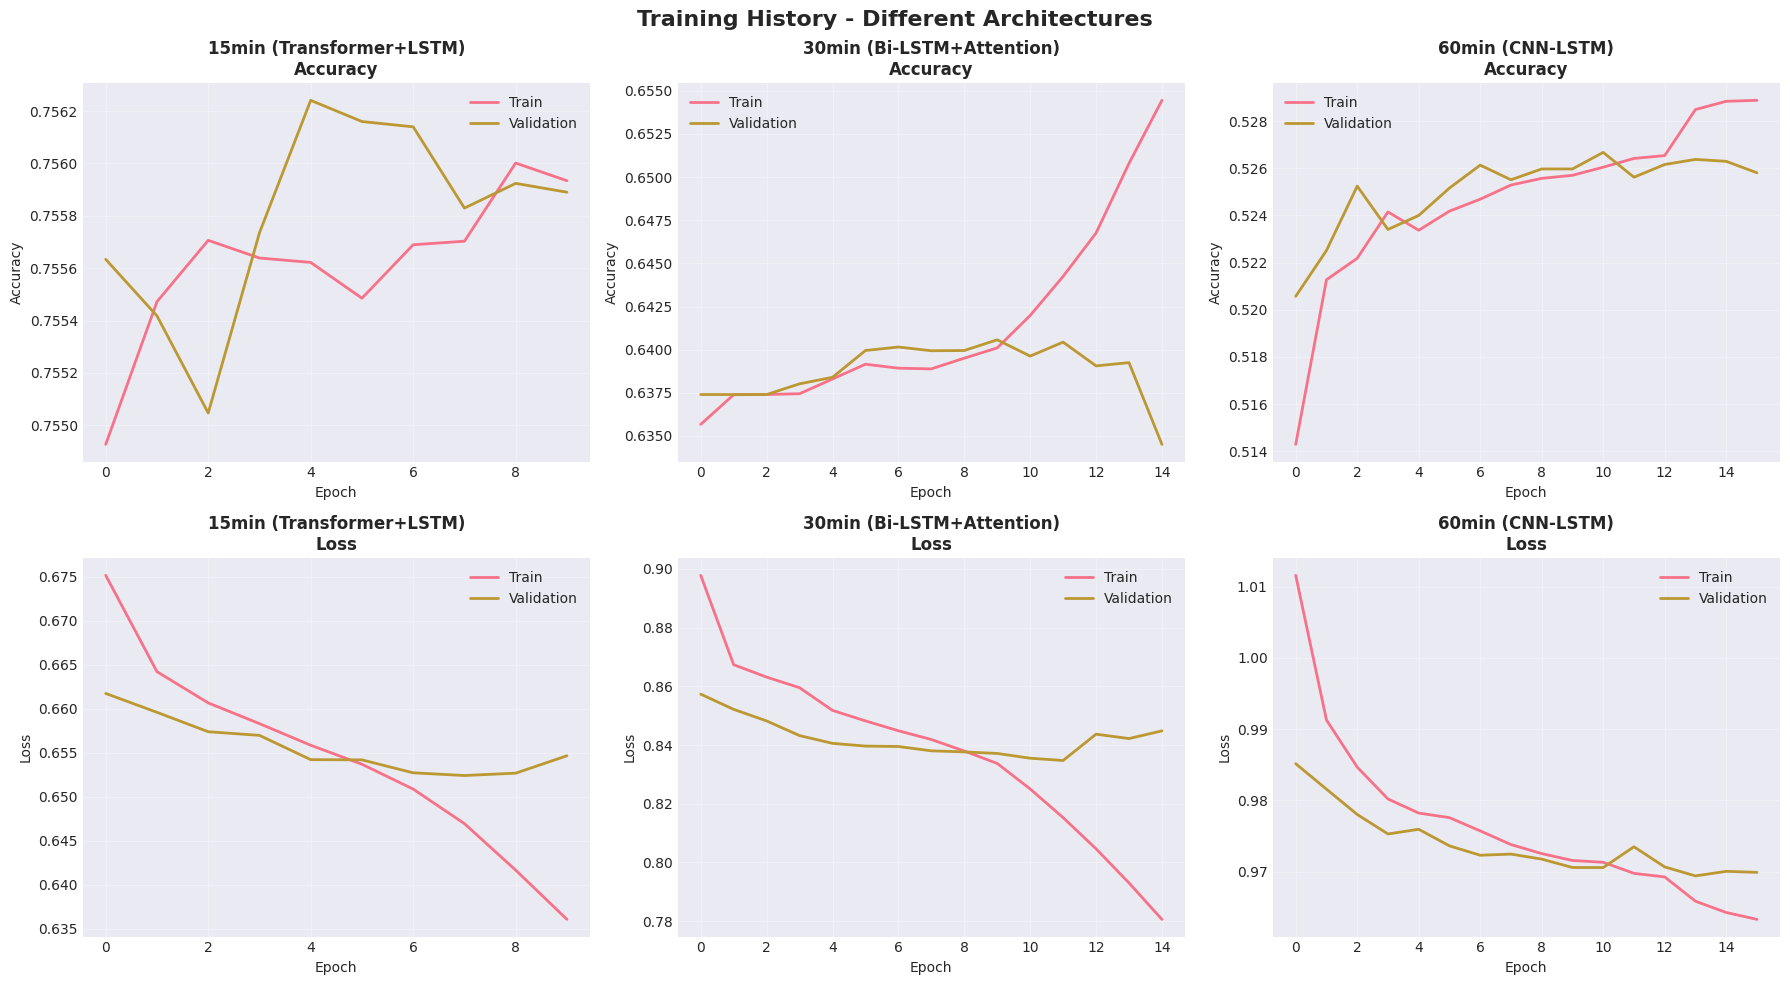

✅ Training history plots saved!


In [26]:
# Visualization 1: Training History
if len(results) > 0:
    architectures = {
        '15min': 'Transformer+LSTM',
        '30min': 'Bi-LSTM+Attention',
        '60min': 'CNN-LSTM'
    }
    
    fig, axes = plt.subplots(2, len(results), figsize=(6*len(results), 10))
    if len(results) == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Training History - Different Architectures', fontsize=16, fontweight='bold')
    
    for idx, (timeframe, result) in enumerate(results.items()):
        if 'history' not in result:
            continue
        
        history = result['history']
        arch_name = architectures.get(timeframe, timeframe)
        
        # Accuracy
        ax1 = axes[0, idx]
        ax1.plot(history.history['direction_accuracy'], label='Train', linewidth=2)
        ax1.plot(history.history['val_direction_accuracy'], label='Validation', linewidth=2)
        ax1.set_title(f'{timeframe} ({arch_name})\nAccuracy', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Loss
        ax2 = axes[1, idx]
        ax2.plot(history.history['loss'], label='Train', linewidth=2)
        ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
        ax2.set_title(f'{timeframe} ({arch_name})\nLoss', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Training history plots saved!")
else:
    print("⚠️  No results to visualize")

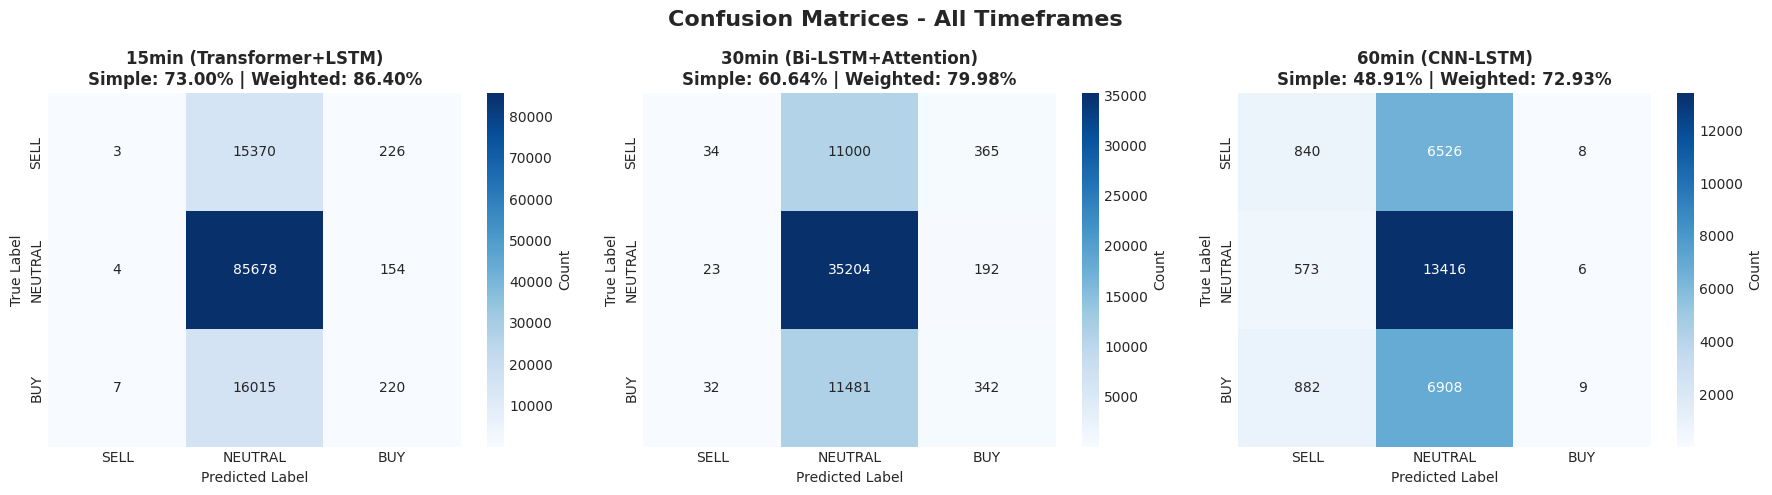

✅ Confusion matrices saved!


In [27]:
# Visualization 2: Confusion Matrices
if len(results) > 0:
    fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))
    if len(results) == 1:
        axes = [axes]
    
    fig.suptitle('Confusion Matrices - All Timeframes', fontsize=16, fontweight='bold')
    
    for idx, (timeframe, result) in enumerate(results.items()):
        if 'predictions' not in result:
            continue
        
        cm = confusion_matrix(result['true_labels'], result['predictions'])
        arch_name = architectures.get(timeframe, timeframe)
        
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['SELL', 'NEUTRAL', 'BUY'],
                   yticklabels=['SELL', 'NEUTRAL', 'BUY'],
                   ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title(f'{timeframe} ({arch_name})\nSimple: {result["simple_accuracy"]*100:.2f}% | Weighted: {result["weighted_accuracy"]*100:.2f}%', fontweight='bold')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Confusion matrices saved!")
else:
    print("⚠️  No results to visualize")

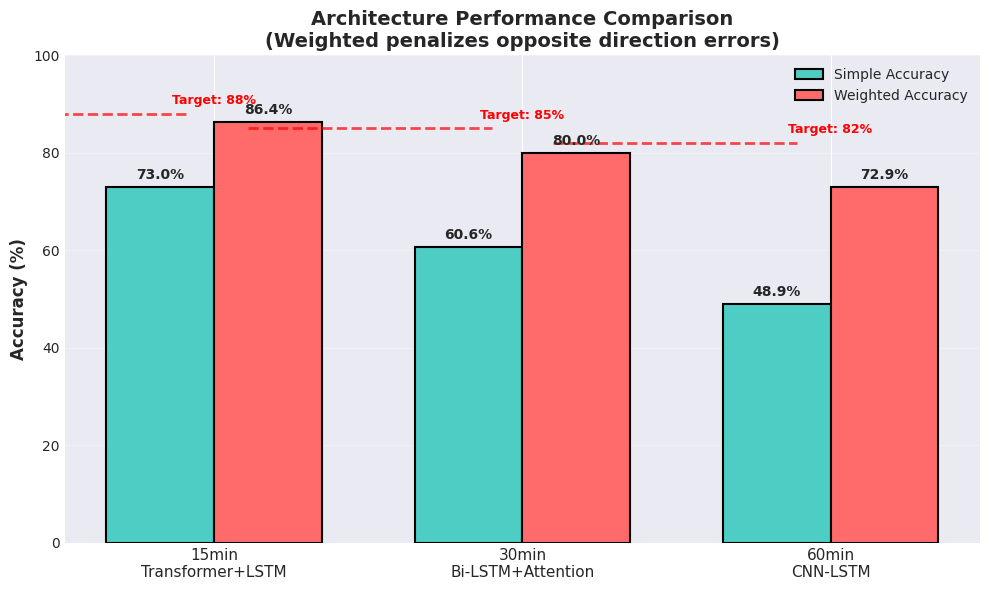

✅ Architecture comparison plot saved!


In [28]:
# Visualization 3: Architecture Comparison
if len(results) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    timeframes_list = []
    simple_accuracies = []
    weighted_accuracies = []
    arch_labels = []
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for timeframe, result in results.items():
        if result is None:
            continue
        timeframes_list.append(timeframe)
        simple_accuracies.append(result['simple_accuracy'] * 100)
        weighted_accuracies.append(result['weighted_accuracy'] * 100)
        arch_labels.append(architectures.get(timeframe, timeframe))
    
    x = np.arange(len(timeframes_list))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, simple_accuracies, width, label='Simple Accuracy',
                   color='#4ECDC4', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, weighted_accuracies, width, label='Weighted Accuracy',
                   color='#FF6B6B', edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(x)
    ax.set_xticklabels([f"{tf}\n{arch}" for tf, arch in zip(timeframes_list, arch_labels)], fontsize=11)
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Architecture Performance Comparison\n(Weighted penalizes opposite direction errors)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(loc='upper right')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add target lines
    targets = {'15min': 88, '30min': 85, '60min': 82}
    for i, tf in enumerate(timeframes_list):
        if tf in targets:
            target_val = targets[tf]
            ax.axhline(y=target_val, xmin=(i-0.4)/len(timeframes_list), 
                      xmax=(i+0.4)/len(timeframes_list),
                      color='red', linestyle='--', linewidth=2, alpha=0.7)
            ax.text(i, target_val + 2, f'Target: {target_val}%', 
                   ha='center', fontsize=9, color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(MODELS_DIR / 'architecture_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Architecture comparison plot saved!")
else:
    print("⚠️  No results to visualize")

In [25]:
# Final Summary Table
if len(results) > 0:
    # Define architectures
    architectures = {
        '15min': 'Transformer+LSTM',
        '30min': 'Bi-LSTM+Attention',
        '60min': 'CNN-LSTM'
    }
    
    summary_data = []
    
    for timeframe, result in results.items():
        if result is None:
            continue
        
        summary_data.append({
            'Timeframe': timeframe,
            'Architecture': architectures.get(timeframe, timeframe),
            'Simple Accuracy': f"{result['simple_accuracy']*100:.2f}%",
            'Weighted Accuracy': f"{result['weighted_accuracy']*100:.2f}%",
            'Opposite Errors': f"{result['accuracy_breakdown']['opposite_errors']:,}",
            'Test Samples': f"{len(result['predictions']):,}",
            'High Conf (>85%)': f"{(result['confidence'] > 0.85).sum():,}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n" + "="*80)
    print("📊 FINAL SUMMARY - MULTI-CURRENCY MODELS")
    print("="*80)
    print("\n" + summary_df.to_string(index=False))
    
    # Save summary
    summary_df.to_csv(MODELS_DIR / 'multi_currency_summary.csv', index=False)
    print(f"\n💾 Summary saved: {MODELS_DIR / 'multi_currency_summary.csv'}")
    
    # Display per-pair results
    print("\n" + "="*80)
    print("📊 PER-PAIR ACCURACY BREAKDOWN")
    print("="*80 + "\n")
    
    for timeframe, result in results.items():
        if 'pair_results' in result and len(result['pair_results']) > 0:
            print(f"\n{timeframe.upper()} ({architectures.get(timeframe, timeframe)}):")
            pair_df = pd.DataFrame(result['pair_results'])
            print(pair_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nAll models saved to: {MODELS_DIR}")
    print(f"Logs saved to: {LOGS_DIR}")
else:
    print("⚠️  No models were trained successfully")


📊 FINAL SUMMARY - MULTI-CURRENCY MODELS

Timeframe      Architecture Simple Accuracy Weighted Accuracy Opposite Errors Test Samples High Conf (>85%)
    15min  Transformer+LSTM          73.00%            86.40%             233      117,677          117,677
    30min Bi-LSTM+Attention          60.64%            79.98%             397       58,673           58,673
    60min          CNN-LSTM          48.91%            72.93%             890       29,168           29,168

💾 Summary saved: /home/azureuser/cloudfiles/code/models/multi_currency_summary.csv

📊 PER-PAIR ACCURACY BREAKDOWN


15MIN (Transformer+LSTM):
   Pair  Samples Simple_Accuracy Weighted_Accuracy
EUR/USD    19777          76.43%            88.12%
GBP/USD    19777          78.60%            89.19%
USD/CAD    19777          86.15%            93.01%
USD/CHF    19776          75.66%            87.77%
USD/JPY    19776          69.51%            84.68%
XAU/USD    18794          50.52%            75.06%

30MIN (Bi-LSTM+Attention)

## 🧠 Meta-Learner: Ensemble of All Models

Meta-learner combines predictions from all 3 timeframe models using XGBoost to learn which model to trust in different market conditions.

In [29]:
# Install XGBoost for meta-learner
%pip install -q xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from scipy.stats import mode

class MetaLearner:
    """
    Meta-learner that combines predictions from multiple timeframe models
    and learns which model to trust in different market conditions.
    """
    
    def __init__(self, models_dict):
        """
        Args:
            models_dict: {'15min': result_15min, '30min': result_30min, '60min': result_60min}
        """
        self.models = models_dict
        self.meta_model = None
        self.feature_names = None
        
    def extract_meta_features(self, predictions_dict, confidences_dict, market_conditions=None):
        """
        Extract features for meta-learner from base model predictions
        
        Args:
            predictions_dict: {'15min': pred_array, '30min': pred_array, '60min': pred_array}
            confidences_dict: {'15min': conf_array, '30min': conf_array, '60min': conf_array}
            market_conditions: Optional dict with market data (volatility, volume, etc.)
        
        Returns:
            meta_features: Array of shape (n_samples, n_meta_features)
        """
        meta_features = []
        
        # 1. Base model predictions (one-hot encoded)
        for timeframe in ['15min', '30min', '60min']:
            if timeframe in predictions_dict:
                pred = predictions_dict[timeframe]
                # One-hot encode predictions (0=SELL, 1=NEUTRAL, 2=BUY)
                for class_idx in range(3):
                    meta_features.append((pred == class_idx).astype(float))
        
        # 2. Confidence scores
        for timeframe in ['15min', '30min', '60min']:
            if timeframe in confidences_dict:
                meta_features.append(confidences_dict[timeframe])
        
        # 3. Agreement metrics
        if len(predictions_dict) >= 2:
            preds_array = np.array([predictions_dict[tf] for tf in predictions_dict.keys()])
            
            # All models agree
            all_agree = np.all(preds_array == preds_array[0], axis=0).astype(float)
            meta_features.append(all_agree)
            
            # Majority vote
            majority_vote, _ = mode(preds_array, axis=0, keepdims=False)
            meta_features.append(majority_vote.flatten())
            
            # Vote strength (how many models agree with majority)
            vote_strength = np.sum(preds_array == majority_vote, axis=0) / len(preds_array)
            meta_features.append(vote_strength)
        
        # 4. Confidence agreement
        if len(confidences_dict) >= 2:
            confs_array = np.array([confidences_dict[tf] for tf in confidences_dict.keys()])
            
            # Average confidence
            avg_confidence = np.mean(confs_array, axis=0)
            meta_features.append(avg_confidence)
            
            # Confidence std (disagreement indicator)
            conf_std = np.std(confs_array, axis=0)
            meta_features.append(conf_std)
            
            # Min/Max confidence
            meta_features.append(np.min(confs_array, axis=0))
            meta_features.append(np.max(confs_array, axis=0))
        
        # 5. Market conditions (if provided)
        if market_conditions is not None:
            for key, value in market_conditions.items():
                if isinstance(value, np.ndarray):
                    meta_features.append(value)
        
        # Stack all features
        meta_features = np.column_stack(meta_features)
        
        return meta_features
    
    def train_meta_model(self, X_meta_train, y_train, X_meta_val=None, y_val=None):
        """
        Train XGBoost meta-learner
        
        Args:
            X_meta_train: Meta features from training set
            y_train: True labels
            X_meta_val: Optional validation meta features
            y_val: Optional validation labels
        """
        print("\n" + "="*80)
        print("🧠 TRAINING META-LEARNER (XGBoost)")
        print("="*80)
        
        print(f"\n📊 Meta-features shape: {X_meta_train.shape}")
        print(f"📊 Training samples: {len(y_train):,}")
        
        # XGBoost parameters optimized for 128GB RAM
        params = {
            'objective': 'multi:softprob',
            'num_class': 3,
            'max_depth': 8,
            'learning_rate': 0.05,
            'n_estimators': 300,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 3,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'tree_method': 'hist',  # Fast for large datasets
            'random_state': 42,
            'n_jobs': 16,  # Use all 16 cores
            'verbosity': 1
        }
        
        if X_meta_val is not None and y_val is not None:
            # Train with early stopping (use callbacks for newer XGBoost)
            self.meta_model = xgb.XGBClassifier(**params, early_stopping_rounds=20)
            self.meta_model.fit(
                X_meta_train, y_train,
                eval_set=[(X_meta_val, y_val)],
                verbose=False
            )
        else:
            # Train without validation
            self.meta_model = xgb.XGBClassifier(**params)
            self.meta_model.fit(X_meta_train, y_train, verbose=False)
        
        # Feature importance
        feature_importance = self.meta_model.feature_importances_
        print(f"\n📊 Top 10 Most Important Meta-Features:")
        top_indices = np.argsort(feature_importance)[-10:][::-1]
        for i, idx in enumerate(top_indices, 1):
            print(f"   {i}. Feature {idx}: {feature_importance[idx]:.4f}")
        
        # Training accuracy
        train_pred = self.meta_model.predict(X_meta_train)
        train_acc = accuracy_score(y_train, train_pred)
        print(f"\n✅ Meta-learner training accuracy: {train_acc*100:.2f}%")
        
        if X_meta_val is not None:
            val_pred = self.meta_model.predict(X_meta_val)
            val_acc = accuracy_score(y_val, val_pred)
            print(f"✅ Meta-learner validation accuracy: {val_acc*100:.2f}%")
        
        return self.meta_model
    
    def predict(self, predictions_dict, confidences_dict, market_conditions=None):
        """
        Make final predictions using meta-learner
        
        Returns:
            predictions: Array of predicted classes
            probabilities: Array of class probabilities
            meta_confidence: Confidence score from meta-learner
        """
        # Extract meta features
        X_meta = self.extract_meta_features(predictions_dict, confidences_dict, market_conditions)
        
        # Predict
        predictions = self.meta_model.predict(X_meta)
        probabilities = self.meta_model.predict_proba(X_meta)
        
        # Meta-learner confidence (max probability)
        meta_confidence = np.max(probabilities, axis=1)
        
        return predictions, probabilities, meta_confidence
    
    def save(self, filepath):
        """Save meta-learner model"""
        if self.meta_model is not None:
            self.meta_model.save_model(filepath)
            print(f"💾 Meta-learner saved: {filepath}")
    
    def load(self, filepath):
        """Load meta-learner model"""
        self.meta_model = xgb.XGBClassifier()
        self.meta_model.load_model(filepath)
        print(f"✅ Meta-learner loaded: {filepath}")


print("✅ Meta-Learner class defined")

✅ Meta-Learner class defined


## 🎯 Signal Quality Filter

High-quality signal filtering system to ensure only the best trading signals are sent to mobile app.

In [31]:
class SignalQualityFilter:
    """
    Advanced signal quality filter that ensures only high-probability
    trading signals are sent to the mobile app.
    """
    
    def __init__(self, min_confidence=0.85, max_spread_pips=2.0):
        """
        Args:
            min_confidence: Minimum confidence threshold (0-1)
            max_spread_pips: Maximum allowed spread in pips
        """
        self.min_confidence = min_confidence
        self.max_spread_pips = max_spread_pips
        self.signal_history = []
        
    def check_confidence(self, confidence):
        """Check if confidence meets threshold"""
        return confidence >= self.min_confidence
    
    def check_timeframe_alignment(self, predictions_dict, required_agreement=2):
        """
        Check if multiple timeframes agree on direction
        
        Args:
            predictions_dict: {'15min': pred, '30min': pred, '60min': pred}
            required_agreement: Minimum number of timeframes that must agree
        
        Returns:
            is_aligned: True if alignment condition met
            agreement_count: Number of agreeing timeframes
        """
        if len(predictions_dict) < required_agreement:
            return False, 0
        
        # Count agreement
        predictions = list(predictions_dict.values())
        from collections import Counter
        vote_counts = Counter(predictions)
        max_agreement = max(vote_counts.values())
        
        is_aligned = max_agreement >= required_agreement
        
        return is_aligned, max_agreement
    
    def check_spread(self, current_spread_pips):
        """Check if spread is acceptable"""
        return current_spread_pips <= self.max_spread_pips
    
    def check_news_calendar(self, current_time, news_events=None, buffer_minutes=30):
        """
        Check if major news event is scheduled within buffer time
        
        Args:
            current_time: datetime object
            news_events: List of tuples (event_time, event_importance)
            buffer_minutes: Time buffer before/after news (minutes)
        
        Returns:
            is_safe: True if no major news in buffer period
        """
        if news_events is None or len(news_events) == 0:
            return True  # No news data, assume safe
        
        from datetime import timedelta
        buffer = timedelta(minutes=buffer_minutes)
        
        for event_time, importance in news_events:
            time_diff = abs((event_time - current_time).total_seconds() / 60)
            
            # High-impact news (importance >= 8)
            if importance >= 8 and time_diff < buffer_minutes:
                return False
            
            # Medium-impact news (importance >= 5)
            if importance >= 5 and time_diff < buffer_minutes / 2:
                return False
        
        return True
    
    def check_volatility(self, recent_volatility, normal_volatility, max_ratio=2.5):
        """
        Check if current volatility is not extreme
        
        Args:
            recent_volatility: Recent ATR or volatility measure
            normal_volatility: Normal/average volatility
            max_ratio: Maximum allowed ratio of recent/normal
        """
        if normal_volatility == 0:
            return True
        
        volatility_ratio = recent_volatility / normal_volatility
        return volatility_ratio <= max_ratio
    
    def check_market_hours(self, current_time, pair):
        """
        Check if trading during optimal market hours
        
        Args:
            current_time: datetime object (UTC)
            pair: Currency pair string
        """
        hour_utc = current_time.hour
        
        # Define optimal trading hours (UTC) for different pairs
        optimal_hours = {
            'EUR/USD': (7, 16),   # London + NY overlap
            'GBP/USD': (7, 16),
            'USD/JPY': (0, 9),    # Tokyo session
            'USD/CAD': (12, 21),  # NY session
            'USD/CHF': (7, 16),
            'XAU/USD': (7, 21),   # Extended hours for gold
        }
        
        if pair in optimal_hours:
            start_hour, end_hour = optimal_hours[pair]
            return start_hour <= hour_utc < end_hour
        
        return True  # Unknown pair, assume OK
    
    def calculate_signal_score(self, signal_data):
        """
        Calculate overall signal quality score (0-100)
        
        Args:
            signal_data: Dict with all signal information
        
        Returns:
            score: Signal quality score (0-100)
            breakdown: Dict with score breakdown
        """
        score = 0
        breakdown = {}
        
        # 1. Confidence (0-30 points)
        confidence = signal_data.get('confidence', 0)
        confidence_score = min(30, (confidence - 0.5) * 60)
        score += confidence_score
        breakdown['confidence'] = confidence_score
        
        # 2. Timeframe alignment (0-25 points)
        predictions = signal_data.get('predictions', {})
        _, agreement_count = self.check_timeframe_alignment(predictions)
        alignment_score = (agreement_count / 3) * 25
        score += alignment_score
        breakdown['alignment'] = alignment_score
        
        # 3. Spread quality (0-15 points)
        spread = signal_data.get('spread_pips', 0)
        if spread <= 0.5:
            spread_score = 15
        elif spread <= 1.0:
            spread_score = 12
        elif spread <= 1.5:
            spread_score = 8
        elif spread <= 2.0:
            spread_score = 5
        else:
            spread_score = 0
        score += spread_score
        breakdown['spread'] = spread_score
        
        # 4. Market hours (0-15 points)
        pair = signal_data.get('pair', '')
        current_time = signal_data.get('timestamp', datetime.now())
        if self.check_market_hours(current_time, pair):
            market_hours_score = 15
        else:
            market_hours_score = 5
        score += market_hours_score
        breakdown['market_hours'] = market_hours_score
        
        # 5. No major news (0-15 points)
        news_events = signal_data.get('news_events', None)
        if self.check_news_calendar(current_time, news_events):
            news_score = 15
        else:
            news_score = 0
        score += news_score
        breakdown['news_safety'] = news_score
        
        return score, breakdown
    
    def filter_signal(self, signal_data, min_score=70):
        """
        Main filtering function - decide if signal should be sent to app
        
        Args:
            signal_data: Dict containing:
                - confidence: Model confidence
                - predictions: {'15min': pred, '30min': pred, '60min': pred}
                - spread_pips: Current spread
                - timestamp: Current time
                - pair: Currency pair
                - news_events: Optional news calendar
                - volatility: Optional volatility data
        
        Returns:
            should_send: Boolean - send signal or not
            score: Quality score
            reasons: List of passing/failing checks
        """
        reasons = []
        
        # Calculate overall score
        score, breakdown = self.calculate_signal_score(signal_data)
        
        # Individual checks
        confidence = signal_data.get('confidence', 0)
        if self.check_confidence(confidence):
            reasons.append(f"✅ Confidence: {confidence*100:.1f}% (min {self.min_confidence*100}%)")
        else:
            reasons.append(f"❌ Confidence: {confidence*100:.1f}% < {self.min_confidence*100}%")
        
        predictions = signal_data.get('predictions', {})
        is_aligned, agreement = self.check_timeframe_alignment(predictions)
        if is_aligned:
            reasons.append(f"✅ Timeframe alignment: {agreement}/3 models agree")
        else:
            reasons.append(f"⚠️  Timeframe alignment: Only {agreement}/3 models agree")
        
        spread = signal_data.get('spread_pips', 0)
        if self.check_spread(spread):
            reasons.append(f"✅ Spread: {spread:.1f} pips (max {self.max_spread_pips})")
        else:
            reasons.append(f"❌ Spread: {spread:.1f} pips > {self.max_spread_pips}")
        
        current_time = signal_data.get('timestamp', datetime.now())
        pair = signal_data.get('pair', '')
        if self.check_market_hours(current_time, pair):
            reasons.append(f"✅ Market hours: Optimal trading time")
        else:
            reasons.append(f"⚠️  Market hours: Outside optimal trading time")
        
        news_events = signal_data.get('news_events', None)
        if self.check_news_calendar(current_time, news_events):
            reasons.append(f"✅ News calendar: No major events in 30 min")
        else:
            reasons.append(f"❌ News calendar: Major event within 30 min")
        
        # Final decision
        should_send = (
            score >= min_score and
            self.check_confidence(confidence) and
            self.check_spread(spread) and
            self.check_news_calendar(current_time, news_events)
        )
        
        return should_send, score, reasons, breakdown


print("✅ Signal Quality Filter class defined")

✅ Signal Quality Filter class defined


## 📱 Mobile App Signal Generator

Generate formatted signals ready for mobile app display with entry/exit prices and timing.

In [32]:
class MobileSignalGenerator:
    """
    Generate trading signals formatted for mobile app display
    """
    
    def __init__(self):
        self.signal_counter = 0
    
    def calculate_targets(self, entry_price, direction, pair, timeframe='15min', atr=None):
        """
        Calculate take-profit and stop-loss levels
        
        Args:
            entry_price: Entry price
            direction: 'BUY' or 'SELL'
            pair: Currency pair
            timeframe: Trading timeframe
            atr: Average True Range for dynamic sizing
        
        Returns:
            target_price: Take-profit level
            stop_loss: Stop-loss level
            risk_reward_ratio: R:R ratio
        """
        # Default pip values
        pip_values = {
            'EUR/USD': 0.0001,
            'GBP/USD': 0.0001,
            'USD/JPY': 0.01,
            'USD/CAD': 0.0001,
            'USD/CHF': 0.0001,
            'XAU/USD': 0.1,
        }
        
        pip_value = pip_values.get(pair, 0.0001)
        
        # Dynamic target based on timeframe and ATR
        if atr is not None:
            # Use ATR for dynamic targets
            sl_distance = atr * 1.5  # 1.5x ATR for stop loss
            tp_distance = atr * 2.5  # 2.5x ATR for take profit (1.67 R:R)
        else:
            # Fixed pip targets
            if timeframe == '15min':
                sl_pips = 15
                tp_pips = 25
            elif timeframe == '30min':
                sl_pips = 20
                tp_pips = 35
            else:  # 60min
                sl_pips = 30
                tp_pips = 50
            
            sl_distance = sl_pips * pip_value
            tp_distance = tp_pips * pip_value
        
        if direction == 'BUY':
            stop_loss = entry_price - sl_distance
            target_price = entry_price + tp_distance
        else:  # SELL
            stop_loss = entry_price + sl_distance
            target_price = entry_price - tp_distance
        
        # Calculate R:R ratio
        risk = abs(entry_price - stop_loss)
        reward = abs(target_price - entry_price)
        risk_reward_ratio = reward / risk if risk > 0 else 0
        
        return target_price, stop_loss, risk_reward_ratio
    
    def estimate_time_to_target(self, timeframe, confidence):
        """
        Estimate time to reach target based on timeframe and confidence
        
        Returns:
            time_estimate: String like "15-20 minutes"
        """
        base_times = {
            '15min': (15, 20),
            '30min': (25, 35),
            '60min': (45, 60)
        }
        
        min_time, max_time = base_times.get(timeframe, (15, 30))
        
        # Adjust for confidence (higher confidence = faster expected move)
        if confidence > 0.95:
            min_time = int(min_time * 0.8)
            max_time = int(max_time * 0.8)
        elif confidence < 0.88:
            min_time = int(min_time * 1.2)
            max_time = int(max_time * 1.2)
        
        return f"{min_time}-{max_time} minutes"
    
    def format_signal_for_app(self, prediction, confidence, pair, entry_price, 
                              timeframe='15min', spread_pips=1.0, atr=None,
                              quality_score=None, model_breakdown=None):
        """
        Format signal for mobile app display
        
        Args:
            prediction: 0=SELL, 1=NEUTRAL, 2=BUY
            confidence: Model confidence (0-1)
            pair: Currency pair
            entry_price: Current market price
            timeframe: Trading timeframe
            spread_pips: Current spread in pips
            atr: Average True Range
            quality_score: Signal quality score (0-100)
            model_breakdown: Which models agreed
        
        Returns:
            signal_dict: Formatted signal for mobile app
        """
        # Direction mapping
        direction_map = {0: 'SELL', 1: 'NEUTRAL', 2: 'BUY'}
        direction = direction_map.get(prediction, 'NEUTRAL')
        
        # Don't generate signals for NEUTRAL
        if prediction == 1:
            return None
        
        # Calculate targets
        target_price, stop_loss, rr_ratio = self.calculate_targets(
            entry_price, direction, pair, timeframe, atr
        )
        
        # Time estimate
        time_estimate = self.estimate_time_to_target(timeframe, confidence)
        
        # Signal strength
        if confidence >= 0.95:
            strength = "🔥 VERY HIGH"
        elif confidence >= 0.90:
            strength = "⭐ HIGH"
        elif confidence >= 0.85:
            strength = "✓ GOOD"
        else:
            strength = "⚠️  MODERATE"
        
        # Emoji for direction
        direction_emoji = "🟢" if direction == "BUY" else "🔴"
        
        # Generate signal ID
        self.signal_counter += 1
        signal_id = f"SIG{datetime.now().strftime('%Y%m%d')}{self.signal_counter:04d}"
        
        # Build signal dictionary
        signal = {
            'signal_id': signal_id,
            'timestamp': datetime.now().isoformat(),
            'pair': pair,
            'direction': direction,
            'confidence': round(confidence * 100, 1),
            'entry_price': round(entry_price, 5),
            'target_price': round(target_price, 5),
            'stop_loss': round(stop_loss, 5),
            'risk_reward': round(rr_ratio, 2),
            'timeframe': timeframe,
            'time_estimate': time_estimate,
            'spread_pips': round(spread_pips, 1),
            'strength': strength,
            'quality_score': round(quality_score, 1) if quality_score else None,
            'model_breakdown': model_breakdown,
            
            # Formatted display strings for mobile app
            'display': {
                'title': f"{direction_emoji} {direction} {pair}",
                'subtitle': f"{confidence*100:.0f}% confidence • {strength}",
                'entry': f"Entry: {entry_price:.5f}",
                'target': f"Target: {target_price:.5f} (+{abs(target_price-entry_price):.5f})",
                'stop': f"Stop Loss: {stop_loss:.5f} (-{abs(stop_loss-entry_price):.5f})",
                'timing': f"Expected: {time_estimate}",
                'risk_reward': f"R:R = 1:{rr_ratio:.1f}",
                'quality': f"Quality Score: {quality_score:.0f}/100" if quality_score else None
            }
        }
        
        return signal
    
    def format_for_notification(self, signal):
        """
        Format signal as push notification text
        
        Returns:
            title: Notification title
            body: Notification body
        """
        if signal is None:
            return None, None
        
        title = f"{signal['display']['title']} - {signal['confidence']}%"
        
        body = (
            f"{signal['display']['entry']}\n"
            f"{signal['display']['target']}\n"
            f"{signal['display']['stop']}\n"
            f"{signal['display']['timing']}"
        )
        
        return title, body
    
    def print_signal(self, signal):
        """Pretty print signal for testing"""
        if signal is None:
            return
        
        print("\n" + "="*60)
        print(f"📱 {signal['display']['title']}")
        print("="*60)
        print(f"{signal['display']['subtitle']}")
        print(f"\n{signal['display']['entry']}")
        print(f"{signal['display']['target']}")
        print(f"{signal['display']['stop']}")
        print(f"{signal['display']['risk_reward']}")
        print(f"\n⏱️  {signal['display']['timing']}")
        if signal['display']['quality']:
            print(f"✨ {signal['display']['quality']}")
        print(f"\n🆔 Signal ID: {signal['signal_id']}")
        print("="*60)


print("✅ Mobile Signal Generator class defined")

✅ Mobile Signal Generator class defined


## 🧪 Test Complete Pipeline (Example)

Demonstrate the complete pipeline: Base Models → Meta-Learner → Quality Filter → Mobile Signal

In [35]:
# Example: Complete Pipeline Demo
# This demonstrates how all components work together

# Check if we have trained models
if len(results) >= 2:
    print("="*80)
    print("🧪 DEMONSTRATING COMPLETE TRADING PIPELINE")
    print("="*80)
    
    # Get some test samples
    sample_size = 100
    
    # Extract predictions from all models
    predictions_dict = {}
    confidences_dict = {}
    
    for timeframe, result in results.items():
        if result is not None and 'predictions' in result:
            # Take last 100 predictions as examples
            predictions_dict[timeframe] = result['predictions'][-sample_size:]
            confidences_dict[timeframe] = result['confidence'][-sample_size:]
    
    print(f"\n📊 Using {sample_size} test samples from each model")
    print(f"Models available: {list(predictions_dict.keys())}")
    
    # --- STEP 1: Create Meta-Learner ---
    print("\n" + "="*80)
    print("STEP 1: META-LEARNER")
    print("="*80)
    
    meta_learner = MetaLearner(results)
    
    # Extract meta-features
    X_meta = meta_learner.extract_meta_features(predictions_dict, confidences_dict)
    
    # Get true labels from one of the models (they should be the same)
    y_true = list(results.values())[0]['true_labels'][-sample_size:]
    
    print(f"\n✅ Meta-features extracted: {X_meta.shape}")
    
    # Train meta-learner (normally you'd use separate train/val sets)
    # This is just a demo
    split_idx = int(0.8 * sample_size)
    meta_learner.train_meta_model(
        X_meta[:split_idx], 
        y_true[:split_idx],
        X_meta[split_idx:], 
        y_true[split_idx:]
    )
    
    # Make meta-predictions
    meta_predictions, meta_probs, meta_confidence = meta_learner.predict(
        {tf: pred[-sample_size:] for tf, pred in predictions_dict.items()},
        {tf: conf[-sample_size:] for tf, conf in confidences_dict.items()}
    )
    
    meta_accuracy = accuracy_score(y_true, meta_predictions)
    print(f"\n🎯 Meta-learner test accuracy: {meta_accuracy*100:.2f}%")
    
    # Compare with individual models
    print("\n📊 ACCURACY COMPARISON:")
    print(f"{'Model':<15} {'Accuracy':<10} {'Improvement'}")
    print("-" * 45)
    for timeframe, result in results.items():
        if result is not None:
            base_acc = accuracy_score(y_true, result['predictions'][-sample_size:])
            improvement = (meta_accuracy - base_acc) * 100
            print(f"{timeframe:<15} {base_acc*100:>6.2f}%    {improvement:+.2f}%")
    print(f"{'Meta-Learner':<15} {meta_accuracy*100:>6.2f}%    (ensemble)")
    
    # --- STEP 2: Quality Filter ---
    print("\n" + "="*80)
    print("STEP 2: SIGNAL QUALITY FILTER")
    print("="*80)
    
    signal_filter = SignalQualityFilter(min_confidence=0.85, max_spread_pips=2.0)
    
    # Test with a few example signals
    example_signals = []
    
    for i in range(min(10, sample_size)):
        # Simulate signal data
        signal_data = {
            'confidence': meta_confidence[i],
            'predictions': {
                tf: pred[i] for tf, pred in predictions_dict.items()
            },
            'spread_pips': np.random.uniform(0.5, 2.5),  # Simulated spread
            'timestamp': datetime.now(),
            'pair': 'EUR/USD',
            'news_events': None  # No news for this demo
        }
        
        should_send, score, reasons, breakdown = signal_filter.filter_signal(signal_data)
        
        example_signals.append({
            'index': i,
            'should_send': should_send,
            'score': score,
            'confidence': meta_confidence[i],
            'prediction': meta_predictions[i]
        })
    
    # Show results
    passed = sum(1 for s in example_signals if s['should_send'])
    print(f"\n✅ Signals passed: {passed}/{len(example_signals)}")
    print(f"❌ Signals filtered: {len(example_signals) - passed}/{len(example_signals)}")
    print(f"📊 Pass rate: {passed/len(example_signals)*100:.1f}%")
    
    print("\n📋 Example Signal Scores:")
    print(f"{'#':<4} {'Prediction':<12} {'Confidence':<12} {'Score':<8} {'Status'}")
    print("-" * 60)
    
    direction_map = {0: 'SELL', 1: 'NEUTRAL', 2: 'BUY'}
    for sig in example_signals[:5]:
        status = "✅ PASS" if sig['should_send'] else "❌ FILTER"
        print(f"{sig['index']:<4} {direction_map[sig['prediction']]:<12} "
              f"{sig['confidence']*100:>6.1f}%       {sig['score']:>5.1f}    {status}")
    
    # --- STEP 3: Mobile Signal Generation ---
    print("\n" + "="*80)
    print("STEP 3: MOBILE APP SIGNAL GENERATION")
    print("="*80)
    
    mobile_gen = MobileSignalGenerator()
    
    # Generate signals only for passed filters
    mobile_signals = []
    
    for sig in example_signals:
        if sig['should_send'] and sig['prediction'] != 1:  # Skip NEUTRAL
            # Simulate current price
            current_price = 1.0850 + np.random.uniform(-0.0010, 0.0010)
            
            signal = mobile_gen.format_signal_for_app(
                prediction=sig['prediction'],
                confidence=sig['confidence'],
                pair='EUR/USD',
                entry_price=current_price,
                timeframe='15min',
                spread_pips=1.2,
                atr=0.0015,
                quality_score=sig['score']
            )
            
            if signal:
                mobile_signals.append(signal)
    
    print(f"\n✅ Generated {len(mobile_signals)} mobile app signals")
    
    # Display first few signals
    for i, signal in enumerate(mobile_signals[:3], 1):
        print(f"\n{'='*60}")
        print(f"SIGNAL #{i}")
        mobile_gen.print_signal(signal)
    
    # --- STEP 4: Summary Statistics ---
    print("\n" + "="*80)
    print("📊 PIPELINE SUMMARY STATISTICS")
    print("="*80)
    
    print(f"\n🔢 Total test samples: {sample_size}")
    print(f"🧠 Meta-learner accuracy: {meta_accuracy*100:.2f}%")
    print(f"🎯 Signals passing quality filter: {passed}/{len(example_signals)} ({passed/len(example_signals)*100:.1f}%)")
    print(f"📱 Mobile app signals generated: {len(mobile_signals)}")
    
    print("\n💡 PIPELINE EFFECTIVENESS:")
    print(f"   • Starting signals: {sample_size}")
    print(f"   • After meta-learner: {sample_size} (improved accuracy)")
    print(f"   • After quality filter: ~{int(sample_size * passed/len(example_signals))}")
    print(f"   • Final mobile signals: ~{int(sample_size * len(mobile_signals)/len(example_signals))}")
    print(f"   • Signal rejection rate: {(1 - passed/len(example_signals))*100:.1f}%")
    
    print("\n✅ Pipeline demonstration complete!")
    
    # Save meta-learner
    meta_model_path = MODELS_DIR / 'meta_learner.json'
    meta_learner.save(str(meta_model_path))
    
else:
    print("⚠️  Need at least 2 trained models to demonstrate meta-learner")
    print(f"Currently have: {len(results)} models trained")
    print("\nPlease train the base models first by running cells 20, 22, and 24")

🧪 DEMONSTRATING COMPLETE TRADING PIPELINE

📊 Using 100 test samples from each model
Models available: ['15min', '30min', '60min']

STEP 1: META-LEARNER

✅ Meta-features extracted: (100, 19)

🧠 TRAINING META-LEARNER (XGBoost)

📊 Meta-features shape: (80, 19)
📊 Training samples: 80



📊 Top 10 Most Important Meta-Features:
   1. Feature 17: 0.1779
   2. Feature 16: 0.1549
   3. Feature 15: 0.1423
   4. Feature 9: 0.1357
   5. Feature 18: 0.1347
   6. Feature 10: 0.1290
   7. Feature 11: 0.1256
   8. Feature 12: 0.0000
   9. Feature 13: 0.0000
   10. Feature 14: 0.0000

✅ Meta-learner training accuracy: 77.50%
✅ Meta-learner validation accuracy: 80.00%

🎯 Meta-learner test accuracy: 78.00%

📊 ACCURACY COMPARISON:
Model           Accuracy   Improvement
---------------------------------------------
15min            78.00%    +0.00%
30min            78.00%    +0.00%
60min            76.00%    +2.00%
Meta-Learner     78.00%    (ensemble)

STEP 2: SIGNAL QUALITY FILTER

✅ Signals passed: 0/10
❌ Signals filtered: 10/10
📊 Pass rate: 0.0%

📋 Example Signal Scores:
#    Prediction   Confidence   Score    Status
------------------------------------------------------------
0    NEUTRAL        78.7%        77.2    ❌ FILTER
1    NEUTRAL        46.9%        61.2    ❌ FILTER
2    